In [1]:
import pandas
import xarray
import requests
import datetime
import numpy as np
import gzip
from tqdm import tqdm as tqdm
from tqdm import tqdm_notebook
import geopandas
import gmaps
import os
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from math import cos, asin, sqrt
import pandas as pd
import warnings 
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
import datetime
from sklearn.ensemble import GradientBoostingClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from multiprocessing import Process
import multiprocessing
warnings.simplefilter('ignore')

height_surf = xarray.open_dataset("./data/hgt.sfc.nc")
land = xarray.open_dataset("./data/land.nc")
nceps = [[], [], [], [], [], [], [], []]
nceps_sfc = [[], [], [], [], [], [], [], []]
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

for index, year in enumerate(years):
    for var in ('hgt', 'srfpt', 'trpp', 'trpt', 'air', 'uwnd', 'vwnd', 'rhum'):
        dataset_filename = './data/{}.{}.nc'.format(var, year)
        nceps[index].append(xarray.open_dataset(dataset_filename))
    nceps[index] = xarray.merge(nceps[index])
    
for index, year in enumerate(years):
    for var in ('air.sfc', 'rhum.sfc', 'vwnd.sfc'):
        dataset_filename = './data/{}.{}.nc'.format(var, year)
        nceps_sfc[index].append(xarray.open_dataset(dataset_filename))
    nceps_sfc[index] = xarray.merge(nceps_sfc[index])

In [2]:
df_train = pandas.read_csv('./wildfires-data-train/wildfires_train.csv')
    
def extract_features(row, index):
    date = row['date']
    dt = datetime.date(int(date[:4]), int(date[5:7]), int(date[8:10]))
    levels = [100, 150, 200, 500, 1000]
    answer = {
        'fire_id': row['fire_id'],
        'month': dt.month,
        'day': dt.day,
        'fire_type': row['fire_type'],
        'fire_type_name': row['fire_type_name'],
        'longitude': row['longitude'],
        'latitude': row['latitude'],
        'date': row['date'],
        'weekday': dt.weekday()}
    
    for level in levels:
        point = nceps[index].sel(
            lon=row['longitude'],
            lat=row['latitude'],
            level=level,
            method='nearest',
        )
        
        p3w = point.rolling(time=21).mean()
        p1w = point.rolling(time=7).mean()
        p2w = point.rolling(time=14).mean()

        v = point.sel(time=date)
        v1w = p1w.sel(time=date)
        v2w = p2w.sel(time=date)
        v3w = p3w.sel(time=date)
        
        answer['temperature ' + str(level)] = v.air.values.item(0)
        answer['humidity ' + str(level)] = v.rhum.values.item(0)
        answer['uwind ' + str(level)] = v.uwnd.values.item(0)
        answer['temperature_1w_mean ' + str(level)] = v1w.air.values.item(0)
        answer['temperature_2w_mean ' + str(level)] = v2w.air.values.item(0)
        answer['temperature_3w_mean ' + str(level)] = v3w.air.values.item(0)
        answer['humidity_1w_mean ' + str(level)] = v1w.rhum.values.item(0)
        answer['humidity_2w_mean ' + str(level)] = v2w.rhum.values.item(0)
        answer['humidity_3w_mean ' + str(level)] = v3w.rhum.values.item(0)
        answer['height_1w_mean' + str(level)] = v1w.hgt.values.item(0)
        answer['height_2w_mean' + str(level)] = v2w.hgt.values.item(0)
        answer['height_3w_mean' + str(level)] = v3w.hgt.values.item(0)
        answer['srfpt_1w_mean' + str(level)] = v1w.srfpt.values.item(0)
        answer['srfpt_2w_mean' + str(level)] = v2w.srfpt.values.item(0)
        answer['srfpt_3w_mean' + str(level)] = v3w.srfpt.values.item(0)
        answer['trpp_1w_mean' + str(level)] = v1w.trpp.values.item(0)
        answer['trpp_2w_mean' + str(level)] = v2w.trpp.values.item(0)
        answer['trpp_3w_mean' + str(level)] = v3w.trpp.values.item(0)
        answer['trpt_1w_mean' + str(level)] = v1w.trpt.values.item(0)
        answer['trpt_2w_mean' + str(level)] = v2w.trpt.values.item(0)
        answer['trpt_3w_mean' + str(level)] = v3w.trpt.values.item(0)
        answer['vwnd_1w_mean' + str(level)] = v1w.vwnd.values.item(0)
        answer['vwnd_2w_mean' + str(level)] = v2w.vwnd.values.item(0)
        answer['vwnd_3w_mean' + str(level)] = v3w.vwnd.values.item(0)
        answer['uwnd_1w_mean' + str(level)] = v1w.uwnd.values.item(0)
        answer['uwnd_2w_mean' + str(level)] = v2w.uwnd.values.item(0)
        answer['uwnd_3w_mean' + str(level)] = v3w.uwnd.values.item(0)
        
    point = nceps_sfc[index].sel(
        lon=row['longitude'],
        lat=row['latitude'],
        method='nearest',
    )

    p3w = point.rolling(time=21).mean()
    p1w = point.rolling(time=7).mean()
    p2w = point.rolling(time=14).mean()

    v = point.sel(time=date)
    v1w = p1w.sel(time=date)
    v2w = p2w.sel(time=date)
    v3w = p3w.sel(time=date)

    answer['temperature_sfc'] = v.air.values.item(0)
    answer['humidity_sfc'] = v.rhum.values.item(0)
    answer['temperature_1w_mean_sfc'] = v1w.air.values.item(0)
    answer['temperature_2w_mean_sfc'] = v2w.air.values.item(0)
    answer['temperature_3w_mean_sfc'] = v3w.air.values.item(0)
    answer['vwnd_1w_mean_sfc'] = v1w.vwnd.values.item(0)
    answer['vwnd_2w_mean_sfc'] = v2w.vwnd.values.item(0)
    answer['vwnd_3w_mean_sfc'] = v3w.vwnd.values.item(0)
    answer['humidity_1w_mean_sfc'] = v1w.rhum.values.item(0)
    answer['humidity_2w_mean_sfc'] = v2w.rhum.values.item(0)
    answer['humidity_3w_mean_sfc'] = v3w.rhum.values.item(0)
        
    return answer

def get_interval_features(query, index, features_list):
    df_subsample = df_train.query(query)
    df_features = []
    for i, row in tqdm(df_subsample.iterrows(), total=df_subsample.shape[0]):
        features = extract_features(row, index)
        df_features.append(features)
    df_features = pandas.DataFrame(df_features).sort_values('date')
    df_features.set_index('fire_id', inplace=True)
    features_list[index] = df_features

def extract_all_basic_features(queries):
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    pool = []
    
    for index, query in enumerate(queries):
        pool.append(Process(target=get_interval_features, args=(query, index, return_dict)))
        pool[index].start()

    for thread in pool:
        thread.join()
    
    return return_dict

# query1213 = '(date > "2012") & (date < "2013")' #распределение сильно отличается
# query1314 = '(date > "2013") & (date < "2014")'
# query1415 = '(date > "2014") & (date < "2015")'
# query1516 = '(date > "2015") & (date < "2016")'
# query1617 = '(date > "2016") & (date < "2017")'
# query1718 = '(date > "2017") & (date < "2018")'
# query1819 = '(date > "2018") & (date < "2019")'
# query1920 = '(date > "2019") & (date < "2020")'

# queries = [query1213, query1314, query1415, query1516, query1617, query1718, query1819, query1920]
# queries_titles = ['2012-2013', '2013-2014', '2014-2015', '2015-2016',
#                   '2016-2017', '2017-2018', '2018-2019', '2019-2020']

# years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

# features_list = extract_all_basic_features(queries).values()

In [3]:
cities_info = pd.read_json('./data/russian-cities.json')
cities_info['latitude'] = cities_info.apply(lambda x: x.coords['lat'], axis=1)
cities_info['longitude'] = cities_info.apply(lambda x: x.coords['lon'], axis=1)
cities_info = cities_info.drop(columns=['coords'])
cities_info['subject'] = cities_info['subject'].astype('category').cat.codes
cities_info['district'] = cities_info['district'].astype('category').cat.codes

forest_info = pd.read_csv('forest_coords.csv')
field_info = pd.read_csv('field_coords.csv')
field_info['field'] = field_info['field'].apply(lambda x: 2)
merged_land_df = pd.concat([forest_info.rename({'forest': 'land_indx'}, axis=1),
                            field_info.rename({'field': 'land_indx'}, axis=1)]).reset_index()
forests_df = pd.read_csv('nature_forests.csv')

In [55]:
def get_radius_counters(df_train, df_test, fire_types, radiuses=[1.5]):
    all_answers_train, all_answers_test = [], []
    
    for radius in tqdm(radiuses):
        answers_train = np.zeros((df_train.shape[0], len(fire_types)))
        answers_test = np.zeros((df_test.shape[0], len(fire_types)))
        for fire_index, fire_type in enumerate(fire_types):
            neigh = NearestNeighbors(10, radius=radius)
            neigh.fit(df_train[df_train.fire_type_name == fire_type][['longitude', 'latitude']])
            
            dist_train, indices_train = neigh.radius_neighbors(df_train[['longitude', 'latitude']])
            dist_test, indices_test = neigh.radius_neighbors(df_test[['longitude', 'latitude']])
            
            for indx, val in enumerate(dist_train):
                ans = len(val)
                if val.shape[0] > 0 and val.min() < 1e-9:
                    ans -= 1
                answers_train[indx][fire_index] = ans
            for indx, val in enumerate(dist_test):
                ans = len(val)
                if val.shape[0] > 0 and val.min() < 1e-9:
                    ans -= 1
                answers_test[indx][fire_index] = ans
        
        
        all_answers_train.append(answers_train)
        all_answers_test.append(answers_test)
            
    return all_answers_train, all_answers_test

def get_radius_cities_amount(df_train, df_test, nearest_cities, radiuses=[1.5]):
    all_answers_train, all_answers_test = [], []
    all_districts_train, all_districts_test = [], []
    all_subj_train, all_subj_test = [], []
    min_dist_train, min_dist_test = np.zeros((df_train.shape[0], 1)), np.zeros((df_test.shape[0], 1))
    
    for radius in tqdm(radiuses):
        answers_train = np.zeros((df_train.shape[0], 1))
        answers_test = np.zeros((df_test.shape[0], 1))
        
        neigh = NearestNeighbors(10, radius=radius)
        neigh.fit(nearest_cities[['longitude', 'latitude']])
        dist_train, indices_train = neigh.radius_neighbors(df_train[['longitude', 'latitude']])
        dist_test, indices_test = neigh.radius_neighbors(df_test[['longitude', 'latitude']])
        
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(nearest_cities[['longitude', 'latitude']], nearest_cities['subject'])
        subject_train = knn.predict(df_train[['longitude', 'latitude']])
        subject_test = knn.predict(df_test[['longitude', 'latitude']])
        
        knn.fit(nearest_cities[['longitude', 'latitude']], nearest_cities['district'])
        district_train = knn.predict(df_train[['longitude', 'latitude']])
        district_test = knn.predict(df_test[['longitude', 'latitude']])
        
        neigh_inf = NearestNeighbors(10, radius=200)
        neigh_inf.fit(nearest_cities[['longitude', 'latitude']])
        min_dist_train, min_ind_train = neigh_inf.radius_neighbors(df_train[['longitude', 'latitude']])
        min_dist_test, min_ind_test = neigh_inf.radius_neighbors(df_test[['longitude', 'latitude']])
                
        for indx, val in enumerate(indices_train):
            answers_train[indx][0] = len(val)
            min_dist_train[indx] = min_dist_train[indx].min()
        for indx, val in enumerate(indices_test):
            answers_test[indx][0] = len(val)
            min_dist_test[indx] = min_dist_test[indx].min()
        
        all_answers_train.append(answers_train)
        all_answers_test.append(answers_test)
        all_districts_train = district_train
        all_districts_test = district_test
        all_subj_train = district_train
        all_subj_test = district_test
    
    return all_answers_train, all_answers_test, all_districts_train, all_districts_test, all_subj_train, all_subj_test, min_dist_train, min_dist_test

def get_radius_land_types_amount(df_train, df_test, land_type_df, radiuses=[1.5]):
    all_answers_train, all_answers_test = [], []
    all_am_train, all_am_test = [], []
    min_dist_train, min_dist_test = np.zeros((df_train.shape[0], 1)), np.zeros((df_test.shape[0], 1))
    
    neigh_inf = NearestNeighbors(1)
    neigh_inf.fit(land_type_df[['longitude', 'latitude']])
    min_dist_train, min_indices_train = neigh_inf.kneighbors(df_train[['longitude', 'latitude']])
    min_dist_test, min_indices_test = neigh_inf.kneighbors(df_test[['longitude', 'latitude']])
    
    for radius in tqdm(radiuses):
        answers_train = np.zeros((df_train.shape[0], 1))
        answers_test = np.zeros((df_test.shape[0], 1))
        am_train, am_test = np.zeros((df_train.shape[0], 1)), np.zeros((df_test.shape[0], 1))
        
        neigh = NearestNeighbors(10, radius=radius)
        neigh.fit(land_type_df[['longitude', 'latitude']])
        dist_train, indices_train = neigh.radius_neighbors(df_train[['longitude', 'latitude']])
        dist_test, indices_test = neigh.radius_neighbors(df_test[['longitude', 'latitude']])
                
        for indx, val in enumerate(dist_train):
            answers_train[indx][0] = min(len(val), 1)
            am_train[indx][0] = len(val)
            min_dist_train[indx] = min_dist_train[indx].min()
        for indx, val in enumerate(dist_test):
            answers_test[indx][0] = min(len(val), 1)
            am_test[indx][0] = len(val)
            min_dist_test[indx] = min_dist_test[indx].min()
        
        all_answers_train.append(answers_train)
        all_answers_test.append(answers_test)
        all_am_train.append(am_train)
        all_am_test.append(am_test)
    
    return all_answers_train, all_answers_test, min_dist_train, min_dist_test, all_am_train, all_am_test

def get_land_class_knn(df_train, df_test, land_type_df):    
    answers_train = np.zeros((df_train.shape[0], 1))
    answers_test = np.zeros((df_test.shape[0], 1))
    am_train, am_test = np.zeros((df_train.shape[0], 1)), np.zeros((df_test.shape[0], 1))

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(land_type_df[['longitude', 'latitude']], land_type_df['land_indx'])
    land_class_train = neigh.predict(df_train[['longitude', 'latitude']])
    land_class_test = neigh.predict(df_test[['longitude', 'latitude']])
    
    return land_class_train, land_class_test

def get_forests_min_dist(df_train, df_test, forests_df):        
    neigh = NearestNeighbors(1)
    neigh.fit(forests_df[['longitude', 'latitude']])
    answers_train, _ = neigh.kneighbors(df_train[['longitude', 'latitude']])
    answers_test, _ = neigh.kneighbors(df_test[['longitude', 'latitude']])
    
    return answers_train, answers_test

def evaluate(y_true, y_pred):
    gt = np.zeros_like(y_pred, dtype=np.int8)
    for index, y in enumerate(y_true):
        gt[index, y - 1] = 1
    result = {'roc_auc_micro': roc_auc_score(gt, y_pred, average='micro')}
    for ft in range(1, 12):
        gt = (y_true == ft)
        if gt.max() == gt.min():
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(gt, y_pred[:, ft - 1])
        result[f'roc_auc_{ft}'] = roc_auc
    return result

def train_model(df_train, df_test, cat_features=[], drop_features=['fire_type', 'date', 'fire_type_name', 'full_date'],
                iterations=1000, max_depth=6, per_float_feature_quantization=[]):
    X_train = df_train.drop(drop_features, axis=1)
    Y_train = df_train.fire_type
    X_val = df_test.drop(drop_features, axis=1)
    Y_val = df_test.fire_type
    
    true_val = df_test.fire_type.tolist()
    print("Start training!")
    print(X_val.shape, Y_val.shape)
    
    clf = catboost.CatBoostClassifier(loss_function='MultiClass',
                                      verbose=10, random_state=42, iterations=iterations, 
                                      od_type = "Iter", od_wait = 100, cat_features=cat_features,
                                      eval_metric="MultiClass", max_depth=max_depth,
                                      per_float_feature_quantization=per_float_feature_quantization)
    clf.fit(X_train, Y_train, eval_set=(X_val, Y_val))
    pred_train = clf.predict_proba(X_train)
    pred_val = clf.predict_proba(X_val)
        
    class_val = clf.predict(X_val)
    train_scores = evaluate(Y_train, pred_train)
    val_scores = evaluate(Y_val, pred_val)
    print("Train scores:")
    for k, v in train_scores.items():
        print("%s\t%f" % (k, v))
    print("Validation scores:")
    for k, v in val_scores.items():
        print("%s\t%f" % (k, v))
    conf_matrix = confusion_matrix(true_val, class_val, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
        
    return clf, conf_matrix, pred_val, class_val

def get_month_radius_counters_prev(df_train, df_test, fire_types, radiuses=[1.5]):
    max_year = df_test.year.values.tolist()[0]
    min_year = min(df_train.year.values.tolist())
    
    result_df_train = pd.DataFrame()
    result_df_test = pd.DataFrame()
    for radius in radiuses:
        result_df_train = pd.concat([result_df_train, pd.DataFrame(np.zeros((df_train.shape[0], 1)), columns=["month_count_last_year_rad=" + str(radius)])], axis=1)
        result_df_test = pd.concat([result_df_test, pd.DataFrame(np.zeros((df_test.shape[0], 1)), columns=["month_count_last_year_rad=" + str(radius)])], axis=1)
        
    for rad_indx, radius in tqdm(enumerate(radiuses)):
        for cur_year in range(min_year + 1, max_year, 1):
            prev_year = cur_year - 1
            for month in range(1, 13, 1):
                neigh_train = NearestNeighbors(10, radius=radius)
                mask_train_prev = (df_train.year <= prev_year) & (df_train.month == month)
                mask_train_cur = (df_train.year == cur_year) & (df_train.month == month)
                if df_train[mask_train_cur].shape[0] == 0 or df_train[mask_train_prev].shape[0] == 0:
                    continue
                neigh_train.fit(df_train[mask_train_prev][['longitude', 'latitude']])
                answers, answers_indx = neigh_train.radius_neighbors(df_train[mask_train_cur][['longitude', 'latitude']])
                for indx, _ in enumerate(answers):
                    answers[indx] = answers[indx].shape[0]
                result_df_train.iloc[:, rad_indx][mask_train_cur] = answers
    
    for rad_indx, radius in tqdm(enumerate(radiuses)):
        cur_year = max_year
        prev_year = cur_year - 1
        for month in range(1, 13, 1):
            neigh_test = NearestNeighbors(10, radius=radius)
            mask_train_prev = (df_train.year <= prev_year) & (df_train.month == month)
            mask_test_cur = (df_test.year == cur_year) & (df_test.month == month)
            if df_test[mask_test_cur].shape[0] == 0 or df_train[mask_train_prev].shape[0] == 0:
                continue
            neigh_test.fit(df_train[mask_train_prev][['longitude', 'latitude']])
            answers, answers_indx = neigh_test.radius_neighbors(df_test[mask_test_cur][['longitude', 'latitude']])
            for indx, _ in enumerate(answers):
                answers[indx] = answers[indx].shape[0]
            result_df_test.iloc[:, rad_indx][mask_test_cur] = answers
    
    
    return result_df_train, result_df_test

In [5]:
# df_features = pd.DataFrame(columns=features_list[0].columns)
# for item in features_list:
#     df_features = pd.concat([df_features, item])
# df_features.head(3)

In [6]:
fire_types = ['технологический процесс', 'техногенный пожар', 'горение мусора', 'сжигание порубочных остатков',
'сжигание мусора', 'неконтролируемый пал', 'торфяной пожар', 'лесной пожар', 'природный пожар', 'контролируемый пал',
'не подтверждено']

In [7]:
df_features = df_features.fillna(0)

In [8]:
df_features['surface_height'] = df_features.apply(lambda x: height_surf.sel(lon=x['longitude'], lat=x['latitude'],
                                                                            method='nearest').hgt.to_dataframe()['hgt'].values.tolist()[0], axis = 1)

df_features['land_mask'] = df_features.apply(lambda x: land.sel(lon=x['longitude'], lat=x['latitude'],
                                                                            method='nearest').land.to_dataframe()['land'].values.tolist()[0], axis = 1)

long_min = 10
lat_min = 35
long_step = 5
lat_step = 5

num_long_areas = df_features['longitude'].max() // long_step + 1
num_lat_areas = df_features['latitude'].max() // lat_step + 1

df_features['latitude_area'] = df_features.apply(lambda x: int((x['latitude'] - lat_min) // lat_step + 1), axis=1)
df_features['longitude_area'] = df_features.apply(lambda x: int((x['longitude'] - long_min) // long_step + 1), axis=1)
df_features['area_num'] = df_features.apply(lambda x: int((x['longitude_area'] - 1) * num_lat_areas + x['latitude_area']), axis=1)
df_features['is_winter'] = df_features.apply(lambda x: int(x['month'] in [12, 1, 2]), axis=1)
df_features['is_autumn'] = df_features.apply(lambda x: int(x['month'] in [9, 10, 11]), axis=1)
df_features['is_summer'] = df_features.apply(lambda x: int(x['month'] in [6, 7, 8]), axis=1)
df_features['is_spring'] = df_features.apply(lambda x: int(x['month'] in [3, 4, 5]), axis=1)
df_features['year'] = df_features.apply(lambda x: int(x.date[:4]), axis=1)

In [161]:
# df_features.to_csv('basic_all_ncep_features.csv', index=False)
df_features = pd.read_csv('basic_all_ncep_features.csv')

In [162]:
columns_to_drop = []
validation_year = '2019'
df_catboost = df_features.copy()
df_catboost['date'] = df_catboost['date'].astype(str)
df_features_val = df_catboost[df_catboost.date.str.contains(pat=validation_year)].drop(columns=columns_to_drop).reset_index()
df_features_train = df_catboost[~df_catboost.date.str.contains(pat=validation_year)].drop(columns=columns_to_drop).reset_index()

In [140]:
df_features_train = df_features

In [163]:
land_class_train, land_class_test = get_land_class_knn(df_features_train, df_features_val, merged_land_df)
nature_forest_min_dist_train, nature_forest_min_dist_test = get_forests_min_dist(df_features_train, df_features_val, forests_df)
radiuses_land = [0.2, 0.5, 1.0]
forest_has_train, forest_has_test, min_dist_forest_train, min_dist_forest_test, am_forest_train, am_forest_test = get_radius_land_types_amount(df_features_train, df_features_val, forest_info, radiuses_land)
field_has_train, field_has_test, min_dist_field_train, min_dist_field_test, am_field_train, am_field_test = get_radius_land_types_amount(df_features_train, df_features_val, field_info, radiuses_land)
radiuses_event = [1.0, 1.5, 2, 2.5]
events_am_rad_month_train, events_am_rad_month_test = get_month_radius_counters_prev(df_features_train, df_features_val, fire_types, radiuses_event)
events_am_rad_train, events_am_rad_test = get_radius_counters(df_features_train, df_features_val, fire_types, radiuses_event)
radiuses_city = [5, 10, 15]
city_am_rad_train, city_am_rad_test, city_district_train, city_district_test, city_subj_train, city_subj_test, city_min_dist_train, city_min_dist_test = get_radius_cities_amount(df_features_train, df_features_val, cities_info, radiuses_city)

100%|██████████| 3/3 [00:02<00:00,  1.02it/s]
4it [00:08,  2.12s/it]
4it [00:01,  2.10it/s]
100%|██████████| 3/3 [00:34<00:00, 11.48s/it]


In [164]:
def concat_features(df_init, additional_info, col_str_list, radiuses=[]):
    if radiuses == []:
        return pd.concat([df_init, pd.DataFrame(additional_info, columns=col_str_list)], axis=1)
    else:
        df_add = np.array(additional_info).copy()
        df_copy = df_init.copy()
        for indx in range(df_add.shape[0]):
            col_str_list_copy = col_str_list.copy()
            for i, col in enumerate(col_str_list_copy):
                col_str_list_copy[i] = col_str_list_copy[i] + "_r=" + str(radiuses[indx])
            df_copy = pd.concat([df_copy, pd.DataFrame(df_add[indx], columns=col_str_list_copy)], axis=1)
        
        return df_copy

def concat_all_features(df_init, fire_types, events_am_rad, events_am_rad_month_df, radiuses_event,
                        forest_has, field_has, radiuses_land,
                        city_am_rad, radiuses_city,
                        city_district, city_min_dist, city_subj, min_dist_forest, nature_forest_min_dist,
                        am_forest, min_dist_field, am_field, land_class):
    
    df_init_copy = df_init.copy()
    
    df_init_copy = concat_features(df_init_copy, events_am_rad, fire_types, radiuses_event)
    df_init_copy = concat_features(df_init_copy, forest_has, ['has_forest'], radiuses_land)
    df_init_copy = concat_features(df_init_copy, field_has, ['has_field'], radiuses_land)
    df_init_copy = concat_features(df_init_copy, city_am_rad, ['amount_cities'], radiuses_city)
    df_init_copy = concat_features(df_init_copy, city_district, ['district'])
    df_init_copy = concat_features(df_init_copy, city_min_dist, ['cities_near_min_dist'])
    df_init_copy = concat_features(df_init_copy, city_subj, ['subject'])
    df_init_copy = concat_features(df_init_copy, min_dist_field, ['field_near_min_dist'])
    df_init_copy = concat_features(df_init_copy, min_dist_forest, ['forest_near_min_dist'])
    df_init_copy = concat_features(df_init_copy, am_field, ['amount_fields'], radiuses_land)
    df_init_copy = concat_features(df_init_copy, am_forest, ['amount_forests'], radiuses_land)
    df_init_copy = concat_features(df_init_copy, land_class, ['land_class'])
    df_init_copy = concat_features(df_init_copy, nature_forest_min_dist, ['nature_forest_min_dist'])
    
    df_init_copy = pd.concat([df_init_copy, events_am_rad_month_df], axis=1)
    
    return df_init_copy



df_features_with_counters_train = concat_all_features(df_features_train, fire_types,
                                                      events_am_rad_train, events_am_rad_month_train,
                                                      radiuses_event,
                                                      forest_has_train, field_has_train, radiuses_land,
                                                      city_am_rad_train, radiuses_city, city_district_train,
                                                      city_min_dist_train, city_subj_train,
                                                      min_dist_forest_train, nature_forest_min_dist_train,
                                                      am_forest_train,
                                                      min_dist_field_train, am_field_train,
                                                      land_class_train)

df_features_with_counters_test = concat_all_features(df_features_val, fire_types,
                                                     events_am_rad_test, events_am_rad_month_test,
                                                     radiuses_event,
                                                     forest_has_test, field_has_test, radiuses_land,
                                                     city_am_rad_test, radiuses_city, city_district_test,
                                                     city_min_dist_test, city_subj_test, 
                                                     min_dist_forest_test, nature_forest_min_dist_test,
                                                     am_forest_test,
                                                     min_dist_field_test, am_field_test,
                                                     land_class_test)

In [165]:
drop_features=['fire_type', 'date', 'fire_type_name', 'latitude_area', 'longitude_area'] + awful_features
if 'index' in df_features_with_counters_train.columns:
    df_features_with_counters_train = df_features_with_counters_train.drop(columns=['index'])
    
if 'index' in df_features_with_counters_test.columns:
    df_features_with_counters_test = df_features_with_counters_test.drop(columns=['index'])
    
cols = list(df_features_with_counters_test.drop(drop_features, axis=1).columns)
    
desired_golden_features = ['year', 'month']
golden_features = []
for feature in desired_golden_features:
    golden_features.append(str(cols.index(feature)) + ':border_count=65534')
golden_features

['129:border_count=65534', '0:border_count=65534']

In [215]:
desired_cat_features = ['month', 'subject']
cat_features = []
for feature in desired_cat_features:
    cat_features.append(cols.index(feature))
    
X_train = df_features_with_counters_train[df_features_with_counters_train.fire_type != 11].drop(drop_features, axis=1)
Y_train = df_features_with_counters_train[df_features_with_counters_train.fire_type != 11].fire_type
X_val = df_features_with_counters_test[df_features_with_counters_test.fire_type != 11].drop(drop_features, axis=1)
Y_val = df_features_with_counters_test[df_features_with_counters_test.fire_type != 11].fire_type

true_val = df_features_with_counters_test[df_features_with_counters_test.fire_type != 11].fire_type.tolist()
print("Start training!") 

clf = catboost.CatBoostClassifier(loss_function='MultiClass',
                                  verbose=10, random_state=42, iterations=5000, 
                                  od_type = "Iter", od_wait = 200, cat_features=cat_features,
                                  eval_metric="MultiClass", max_depth=6,
                                  per_float_feature_quantization=golden_features)
clf.fit(X_train, Y_train, eval_set=(X_val, Y_val))
pred_train = clf.predict_proba(X_train)
pred_val = clf.predict_proba(X_val)

class_val = clf.predict(X_val)
train_scores = evaluate(Y_train, pred_train)
val_scores = evaluate(Y_val, pred_val)
print("Train scores:")
for k, v in train_scores.items():
    print("%s\t%f" % (k, v))
print("Validation scores:")
for k, v in val_scores.items():
    print("%s\t%f" % (k, v))
conf_matrix = confusion_matrix(true_val, class_val, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
conf_matrix

Start training!
0:	learn: 2.2102269	test: 2.2109774	best: 2.2109774 (0)	total: 891ms	remaining: 1h 14m 15s
10:	learn: 1.7155227	test: 1.7149625	best: 1.7149625 (10)	total: 12.7s	remaining: 1h 35m 51s
20:	learn: 1.4854800	test: 1.4922826	best: 1.4922826 (20)	total: 24.2s	remaining: 1h 35m 33s
30:	learn: 1.3381257	test: 1.3508026	best: 1.3508026 (30)	total: 35.8s	remaining: 1h 35m 30s
40:	learn: 1.2401639	test: 1.2628148	best: 1.2628148 (40)	total: 47.3s	remaining: 1h 35m 15s
50:	learn: 1.1696256	test: 1.2076358	best: 1.2076358 (50)	total: 59.3s	remaining: 1h 35m 53s
60:	learn: 1.1203474	test: 1.1673416	best: 1.1673416 (60)	total: 1m 10s	remaining: 1h 35m 16s
70:	learn: 1.0809700	test: 1.1397537	best: 1.1397537 (70)	total: 1m 21s	remaining: 1h 34m 45s
80:	learn: 1.0512145	test: 1.1223926	best: 1.1223926 (80)	total: 1m 33s	remaining: 1h 34m 26s
90:	learn: 1.0285992	test: 1.1090831	best: 1.1090831 (90)	total: 1m 44s	remaining: 1h 34m 7s
100:	learn: 1.0103679	test: 1.1007597	best: 1.1007597

860:	learn: 0.7345465	test: 1.0443709	best: 1.0438590 (844)	total: 16m 50s	remaining: 1h 20m 56s
870:	learn: 0.7331483	test: 1.0443869	best: 1.0438590 (844)	total: 17m 1s	remaining: 1h 20m 42s
880:	learn: 0.7317523	test: 1.0440649	best: 1.0438590 (844)	total: 17m 12s	remaining: 1h 20m 28s
890:	learn: 0.7303906	test: 1.0433460	best: 1.0433460 (890)	total: 17m 24s	remaining: 1h 20m 15s
900:	learn: 0.7291751	test: 1.0429025	best: 1.0429025 (900)	total: 17m 35s	remaining: 1h 20m 1s
910:	learn: 0.7277131	test: 1.0429844	best: 1.0427808 (904)	total: 17m 46s	remaining: 1h 19m 49s
920:	learn: 0.7264708	test: 1.0428278	best: 1.0427808 (904)	total: 17m 58s	remaining: 1h 19m 35s
930:	learn: 0.7252256	test: 1.0423353	best: 1.0423353 (930)	total: 18m 9s	remaining: 1h 19m 22s
940:	learn: 0.7239845	test: 1.0426745	best: 1.0423353 (930)	total: 18m 21s	remaining: 1h 19m 9s
950:	learn: 0.7228737	test: 1.0421647	best: 1.0420071 (944)	total: 18m 32s	remaining: 1h 18m 56s
960:	learn: 0.7215754	test: 1.0421

array([[  35,    0,    0,    3,    0,    2,    0,    0,    9,    5],
       [   0,    0,    1,    7,    0,    7,    0,    1,   22,   28],
       [   2,    0,   45,   17,    0,   14,    0,    1,  149,   13],
       [  16,    0,   18,  265,    2,   40,    0,    1,   73,  194],
       [   3,    0,   11,   28,    5,   42,    0,    4,   46,   62],
       [   0,    0,    0,   35,    0, 2808,    0,   21,  810,  564],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    2,    0,  151,    0,   43,   95,   54],
       [   5,    0,   16,   13,    0,  609,    0,   27, 3817,  364],
       [   6,    0,    5,  193,    0,  596,    0,   12,  535, 1405]])

In [1]:
df_features_with_counters_train

NameError: name 'df_features_with_counters_train' is not defined

In [216]:
feature_scores = {}
# awful_features = []
for score, name in zip(clf.feature_importances_, clf.feature_names_):
    feature_scores[name] = score
#     if score < 1e-4:
#         awful_features.append(name)
    
feature_scores = sorted(feature_scores.items(), key=lambda kv: kv[1])
feature_scores

[('trpp_1w_mean500', 0.023033218614126216),
 ('trpt_2w_mean100', 0.0341176783254281),
 ('trpt_1w_mean200', 0.04847793961070532),
 ('trpp_1w_mean150', 0.05191780055974061),
 ('trpp_1w_mean200', 0.05558613045669856),
 ('trpt_1w_mean500', 0.0634038049584983),
 ('trpp_2w_mean1000', 0.06516457337742418),
 ('trpt_2w_mean150', 0.06788538038937098),
 ('trpt_2w_mean500', 0.06918666578849696),
 ('trpp_3w_mean100', 0.06989882435198212),
 ('trpp_2w_mean500', 0.07922004986279003),
 ('trpt_1w_mean100', 0.080048068457705),
 ('trpt_2w_mean1000', 0.08166200700540817),
 ('trpt_1w_mean1000', 0.081785001356223),
 ('trpp_2w_mean150', 0.08479892224142913),
 ('trpt_3w_mean150', 0.08721350335058664),
 ('не подтверждено_r=1.5', 0.08931905741107408),
 ('trpp_3w_mean500', 0.08998649624811278),
 ('trpp_1w_mean1000', 0.097376743799913),
 ('amount_forests_r=0.2', 0.10016176513911247),
 ('srfpt_1w_mean100', 0.10133494152518567),
 ('trpp_3w_mean1000', 0.10534358927483785),
 ('trpp_3w_mean150', 0.1118549604837729),
 (

In [211]:
accuracy_score(class_val.reshape(-1), df_features_val.fire_type.values.tolist()) #0.688

0.5543688714009118

In [156]:
df_features_with_counters_train.to_csv('./solution/df_features_train.csv', index=False)

по городу (5, 10) и до 3 радиус и ближ расст до города и область - 0.5405, 1.214 - кат фича месяц, год. область AUC = 0.9254 (1.213 abs min)
проверяется гипотеза о новых данных наса + топ фичи - 0.5522, 1.199 - кат фича месяц, субъект 0.9272

In [157]:
import pickle

with open('solution/model.pickle', 'wb') as fout:
    pickle.dump(clf, fout, protocol=pickle.HIGHEST_PROTOCOL)

In [171]:
fire_types = ['технологический процесс', 'техногенный пожар', 'горение мусора', 'сжигание порубочных остатков',
'сжигание мусора', 'неконтролируемый пал', 'торфяной пожар', 'лесной пожар', 'природный пожар', 'контролируемый пал',
'не подтверждено']

In [208]:
labels=[9, 11]
X_train_tmp = df_features_with_counters_train[df_features_with_counters_train.fire_type.isin(labels)].drop(drop_features, axis=1)
Y_train_tmp = df_features_with_counters_train[df_features_with_counters_train.fire_type.isin(labels)].fire_type
X_val_tmp = df_features_with_counters_test[df_features_with_counters_test.fire_type.isin(labels)].drop(drop_features, axis=1)
Y_val_tmp = df_features_with_counters_test[df_features_with_counters_test.fire_type.isin(labels)].fire_type

desired_cat_features = ['subject']
cat_features = []
for feature in desired_cat_features:
    cat_features.append(cols.index(feature))

true_val = df_features_with_counters_test[df_features_with_counters_test.fire_type.isin(labels)].fire_type.tolist()
print("Start training!") 

clf = catboost.CatBoostClassifier(loss_function='MultiClass',
                                  verbose=10, random_state=42, iterations=5000, 
                                  od_type = "Iter", od_wait = 200, cat_features=cat_features,
                                  eval_metric="MultiClass", max_depth=8,
                                  per_float_feature_quantization=golden_features)
clf.fit(X_train_tmp, Y_train_tmp, eval_set=(X_val_tmp, Y_val_tmp))
pred_val = clf.predict_proba(X_val_tmp)

class_val = clf.predict(X_val_tmp)
conf_matrix = confusion_matrix(true_val, class_val, labels=labels)
print(conf_matrix)
print(conf_matrix.diagonal().sum() / conf_matrix.sum())

Start training!
0:	learn: 0.6870848	test: 0.6883689	best: 0.6883689 (0)	total: 105ms	remaining: 8m 42s
10:	learn: 0.6404123	test: 0.6546962	best: 0.6546962 (10)	total: 1.33s	remaining: 10m 5s
20:	learn: 0.6102849	test: 0.6339080	best: 0.6339080 (20)	total: 2.48s	remaining: 9m 47s
30:	learn: 0.5892896	test: 0.6218347	best: 0.6218347 (30)	total: 3.71s	remaining: 9m 55s
40:	learn: 0.5746624	test: 0.6117724	best: 0.6117724 (40)	total: 4.91s	remaining: 9m 53s
50:	learn: 0.5629661	test: 0.6047178	best: 0.6047178 (50)	total: 6.03s	remaining: 9m 45s
60:	learn: 0.5539308	test: 0.5997642	best: 0.5997642 (60)	total: 7.14s	remaining: 9m 38s
70:	learn: 0.5470474	test: 0.5977886	best: 0.5977886 (70)	total: 8.24s	remaining: 9m 32s
80:	learn: 0.5415647	test: 0.5956846	best: 0.5956846 (80)	total: 9.4s	remaining: 9m 30s
90:	learn: 0.5367046	test: 0.5937969	best: 0.5936649 (89)	total: 10.6s	remaining: 9m 32s
100:	learn: 0.5320686	test: 0.5922920	best: 0.5922920 (100)	total: 11.9s	remaining: 9m 37s
110:	l

900:	learn: 0.4217231	test: 0.5759093	best: 0.5757555 (864)	total: 2m 1s	remaining: 9m 11s
910:	learn: 0.4209573	test: 0.5761500	best: 0.5757555 (864)	total: 2m 2s	remaining: 9m 9s
920:	learn: 0.4200593	test: 0.5763403	best: 0.5757555 (864)	total: 2m 3s	remaining: 9m 8s
930:	learn: 0.4193570	test: 0.5762180	best: 0.5757555 (864)	total: 2m 5s	remaining: 9m 7s
940:	learn: 0.4186568	test: 0.5763288	best: 0.5757555 (864)	total: 2m 6s	remaining: 9m 5s
950:	learn: 0.4178692	test: 0.5760134	best: 0.5757555 (864)	total: 2m 7s	remaining: 9m 4s
960:	learn: 0.4171621	test: 0.5758417	best: 0.5757555 (864)	total: 2m 9s	remaining: 9m 2s
970:	learn: 0.4162500	test: 0.5761898	best: 0.5757555 (864)	total: 2m 10s	remaining: 9m 1s
980:	learn: 0.4155028	test: 0.5763556	best: 0.5757555 (864)	total: 2m 11s	remaining: 9m
990:	learn: 0.4147652	test: 0.5766474	best: 0.5757555 (864)	total: 2m 13s	remaining: 8m 58s
1000:	learn: 0.4139814	test: 0.5763157	best: 0.5757555 (864)	total: 2m 14s	remaining: 8m 57s
1010:

In [200]:
feature_scores = {}
for score, name in zip(clf.feature_importances_, clf.feature_names_):
    feature_scores[name] = score
    
feature_scores = sorted(feature_scores.items(), key=lambda kv: kv[1])
feature_scores

[('day', 0.0),
 ('weekday', 0.0),
 ('temperature 100', 0.0),
 ('uwind 100', 0.0),
 ('temperature_1w_mean 100', 0.0),
 ('temperature_2w_mean 100', 0.0),
 ('height_2w_mean100', 0.0),
 ('height_3w_mean100', 0.0),
 ('srfpt_2w_mean100', 0.0),
 ('trpp_2w_mean100', 0.0),
 ('trpt_1w_mean100', 0.0),
 ('trpt_2w_mean100', 0.0),
 ('trpt_3w_mean100', 0.0),
 ('vwnd_1w_mean100', 0.0),
 ('vwnd_2w_mean100', 0.0),
 ('vwnd_3w_mean100', 0.0),
 ('uwnd_2w_mean100', 0.0),
 ('uwnd_3w_mean100', 0.0),
 ('temperature 150', 0.0),
 ('uwind 150', 0.0),
 ('temperature_1w_mean 150', 0.0),
 ('temperature_2w_mean 150', 0.0),
 ('temperature_3w_mean 150', 0.0),
 ('height_1w_mean150', 0.0),
 ('height_3w_mean150', 0.0),
 ('srfpt_1w_mean150', 0.0),
 ('srfpt_2w_mean150', 0.0),
 ('trpp_1w_mean150', 0.0),
 ('trpp_2w_mean150', 0.0),
 ('trpt_2w_mean150', 0.0),
 ('trpt_3w_mean150', 0.0),
 ('vwnd_1w_mean150', 0.0),
 ('vwnd_2w_mean150', 0.0),
 ('vwnd_3w_mean150', 0.0),
 ('uwnd_1w_mean150', 0.0),
 ('uwind 200', 0.0),
 ('temperature_

In [120]:
tmp_df = pd.concat([pd.DataFrame(class_val.astype(int), columns=['tmp']), df_features_with_counters_test], axis=1)
errors_tmp_df = tmp_df[tmp_df.tmp != tmp_df.fire_type]

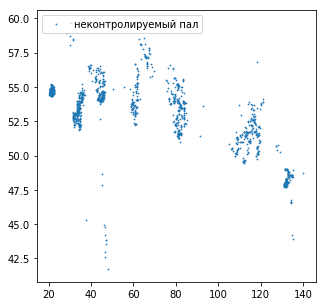

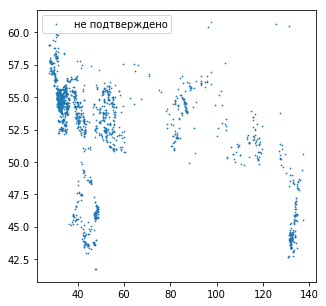

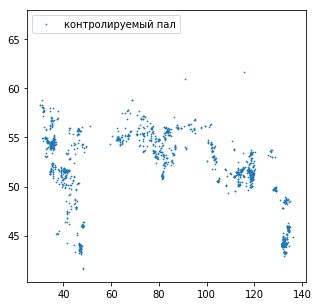

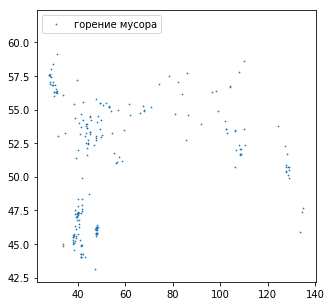

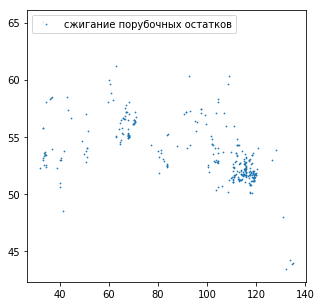

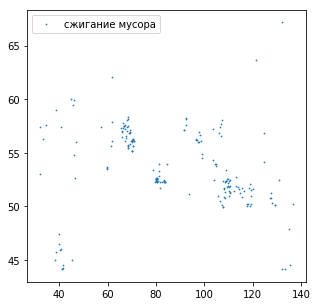

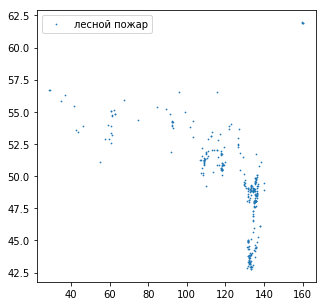

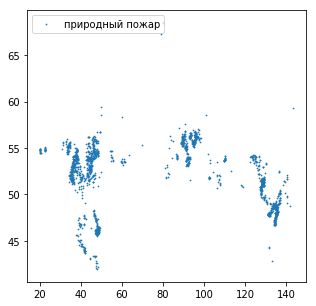

In [122]:
def plot_map_fire(df_features, fire_type):
    coords = df_features[df_features['fire_type_name'] == fire_type][['longitude', 'latitude']].values.tolist()
    coords_x_long = [x[0] for x in coords]
    coords_y_lat = [x[1] for x in coords]
    plt.scatter(coords_x_long, coords_y_lat, label=fire_type, s=0.5)
    plt.legend(loc='upper left');
    plt.show()
    
plot_map_fire(errors_tmp_df, 'неконтролируемый пал')
plot_map_fire(errors_tmp_df, 'не подтверждено')
plot_map_fire(errors_tmp_df, 'контролируемый пал')
plot_map_fire(errors_tmp_df, 'горение мусора')
plot_map_fire(errors_tmp_df, 'сжигание порубочных остатков')
plot_map_fire(errors_tmp_df, 'сжигание мусора')
plot_map_fire(errors_tmp_df, 'лесной пожар')
plot_map_fire(errors_tmp_df, 'природный пожар')